# Heart Rate Synchronization - Data Exploration
 
This notebook explores heart rate and audio data for the Heart Rate Synchronization project.


In [39]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from scipy import stats, signal
import os
import sys

# Import project modules
from src.preprocess import preprocess_heart_rate, preprocess_audio, segment_data
from src.features import extract_heart_rate_features, extract_audio_features, extract_all_features
from src.synchronization import calculate_pearson_correlation, calculate_windowwise_correlation, binary_synchronization
from src.context import classify_audio_contexts, create_multidimensional_contexts, analyze_context_synchronization
from src.analysis import compute_effect_sizes, apply_multiple_testing_correction
from src.visualize import plot_timeline, plot_effect_sizes, plot_context_heatmap
from config import PROCESSING_CONFIG, SYNC_CONFIG


# Add project root to path to enable imports
sys.path.append('..')

# Import project modules
from src.preprocess import preprocess_heart_rate, preprocess_audio
from config import PROCESSING_CONFIG

# Set plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')
# %matplotlib inline - This will work when converted to a notebook

# 1. Load and Explore Heart Rate Data

Participant 1 Heart Rate Data:
   timestamp  heart_rate
0        0.0   70.201228
1        1.0   70.662887
2        2.0   70.772956
3        3.0   70.783374
4        4.0   71.282994

Participant 2 Heart Rate Data:
   timestamp  heart_rate
0        0.0   75.201228
1        1.0   75.662887
2        2.0   75.772956
3        3.0   75.783374
4        4.0   76.282994


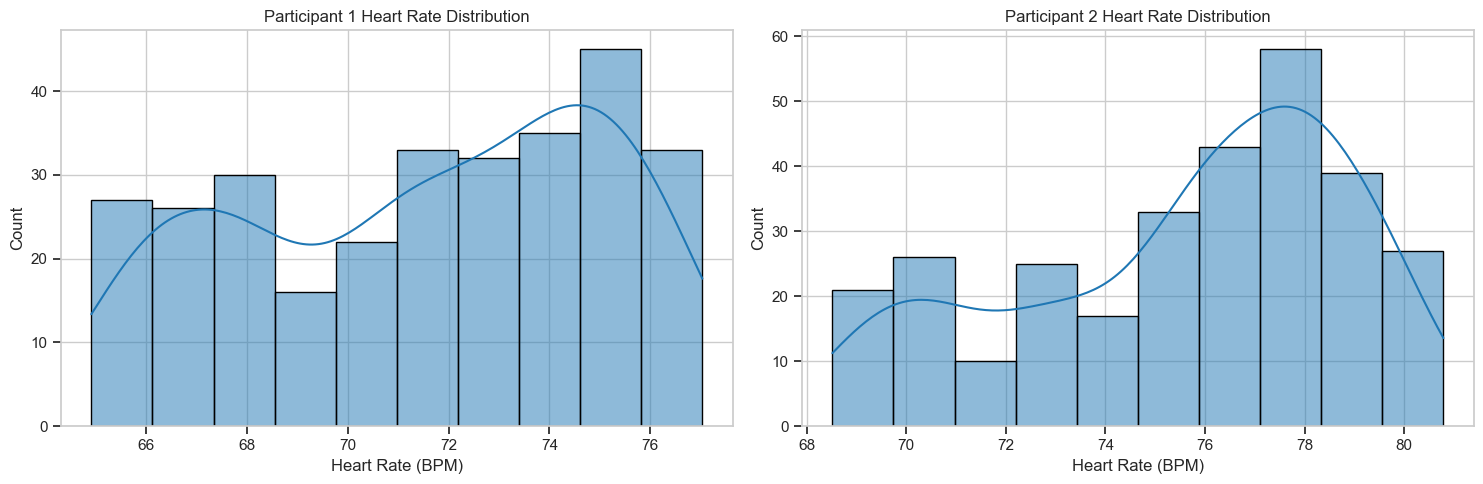

       Participant 1  Participant 2
count     299.000000     299.000000
mean       71.529353      75.581193
std         3.556481       3.312016
min        64.917670      68.514945
25%        68.167246      73.056057
50%        72.009725      76.282994
75%        74.663392      78.060632
max        77.031369      80.789914


In [40]:
# Define data paths
# Replace with your actual data paths
hr_file1 = '../data/raw/participant1_hr.csv'
hr_file2 = '../data/raw/participant2_hr.csv'

# Check if files exist
if os.path.exists(hr_file1) and os.path.exists(hr_file2):
    # Load heart rate data
    hr_data1 = pd.read_csv(hr_file1)
    hr_data2 = pd.read_csv(hr_file2)
    
    print("Participant 1 Heart Rate Data:")
    print(hr_data1.head())
    print("\nParticipant 2 Heart Rate Data:")
    print(hr_data2.head())
else:
    print("Heart rate data files not found. Please update the file paths.")

# %% [markdown]
# ### 1.1 Explore Heart Rate Data Distribution

# %%
# Check if files exist before proceeding
if os.path.exists(hr_file1) and os.path.exists(hr_file2):
    # Preprocess heart rate data
    processed_hr1 = preprocess_heart_rate(hr_data1, 'p1')
    processed_hr2 = preprocess_heart_rate(hr_data2, 'p2')
    
    # Plot histograms of heart rates
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(processed_hr1['heart_rate'], kde=True, ax=axes[0])
    axes[0].set_title('Participant 1 Heart Rate Distribution')
    axes[0].set_xlabel('Heart Rate (BPM)')
    
    sns.histplot(processed_hr2['heart_rate'], kde=True, ax=axes[1])
    axes[1].set_title('Participant 2 Heart Rate Distribution')
    axes[1].set_xlabel('Heart Rate (BPM)')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate basic statistics
    stats1 = processed_hr1['heart_rate'].describe()
    stats2 = processed_hr2['heart_rate'].describe()
    
    stats_df = pd.concat([stats1, stats2], axis=1)
    stats_df.columns = ['Participant 1', 'Participant 2']
    print(stats_df)



### 1.2 Plot Heart Rate Time Series


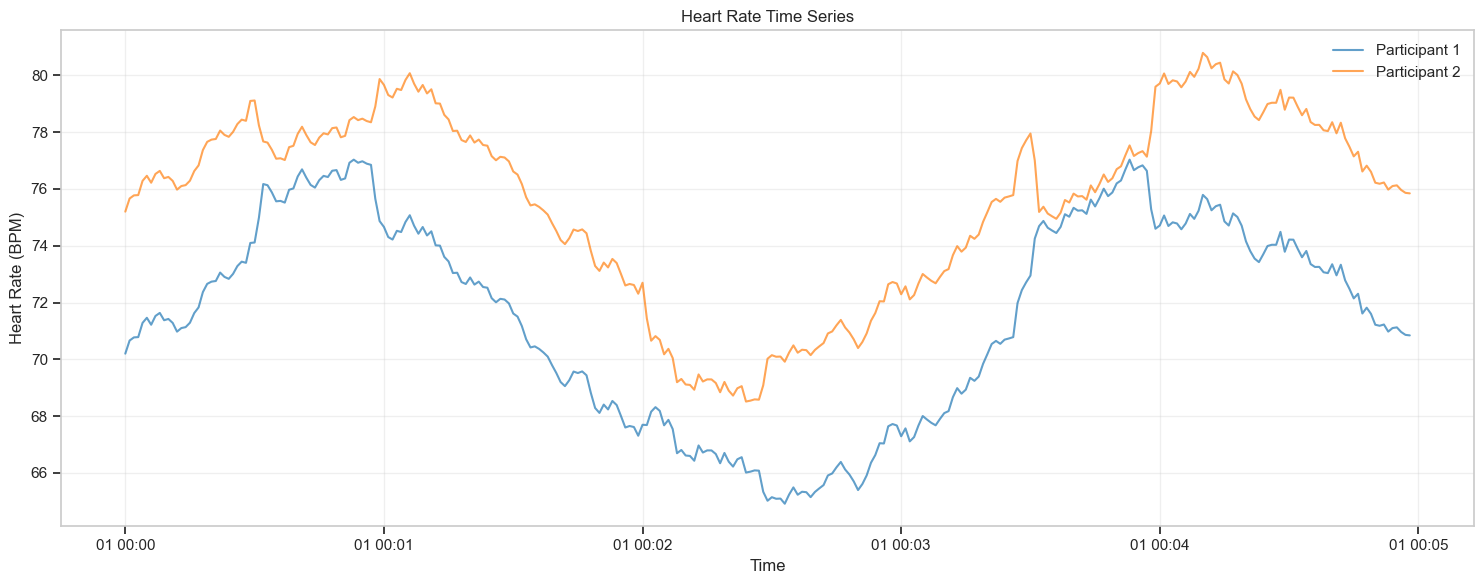

In [41]:
# Check if files exist before proceeding
if os.path.exists(hr_file1) and os.path.exists(hr_file2):
    # Plot heart rate time series
    plt.figure(figsize=(15, 6))
    
    # Convert timestamps to datetime for better x-axis labels
    processed_hr1['datetime'] = pd.to_datetime(processed_hr1['timestamp'], unit='s')
    processed_hr2['datetime'] = pd.to_datetime(processed_hr2['timestamp'], unit='s')
    
    plt.plot(processed_hr1['datetime'], processed_hr1['heart_rate'], label='Participant 1', alpha=0.7)
    plt.plot(processed_hr2['datetime'], processed_hr2['heart_rate'], label='Participant 2', alpha=0.7)
    
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (BPM)')
    plt.title('Heart Rate Time Series')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## 2. Load and Explore Audio Data


In [42]:
# Define audio file path
# Replace with your actual audio path
# audio_file = '../data/raw/session_audio.wav'
audio_file = '../data/raw/audio_track.mp3'

# Check if file exists
if os.path.exists(audio_file):
    # Load and preprocess audio
    audio_data, sr = preprocess_audio(audio_file)
    
    print(f"Audio sample rate: {sr} Hz")
    print(f"Audio duration: {len(audio_data) / sr:.2f} seconds")
    print(f"Number of samples: {len(audio_data)}")
else:
    print("Audio file not found. Please update the file path.")


Audio sample rate: 44100 Hz
Audio duration: 637.84 seconds
Number of samples: 28128741


### 2.1 Visualize Audio Waveform


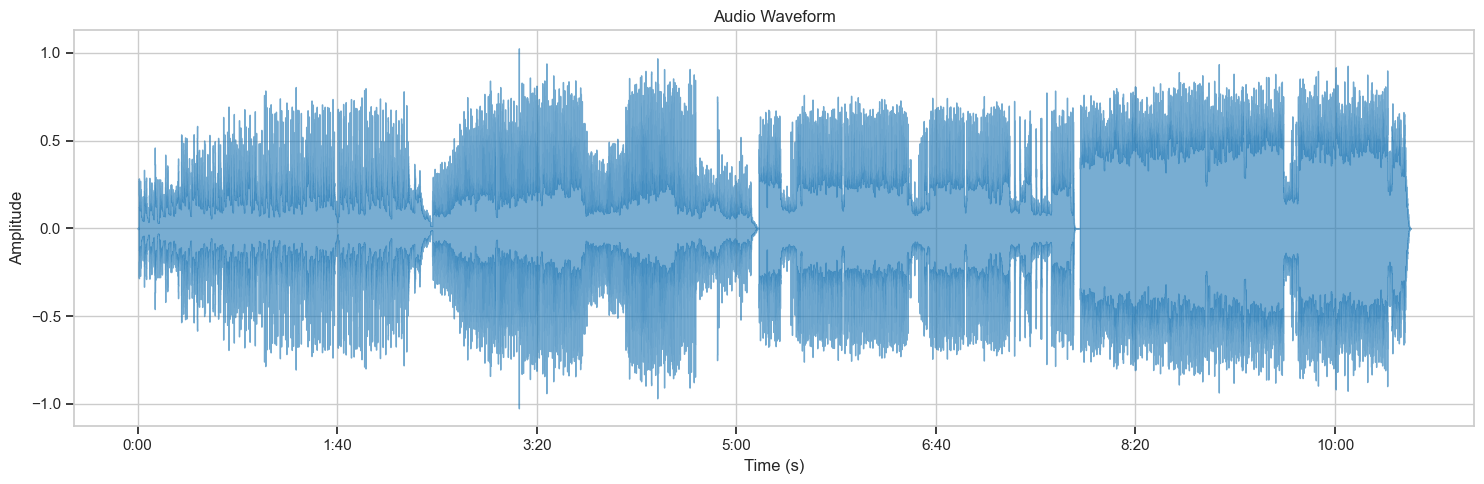

In [43]:

# Check if file exists before proceeding
if os.path.exists(audio_file):
    # Plot audio waveform
    plt.figure(figsize=(15, 5))
    librosa.display.waveshow(audio_data, sr=sr, alpha=0.6)
    plt.title('Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()


### 2.2 Visualize Spectrogram


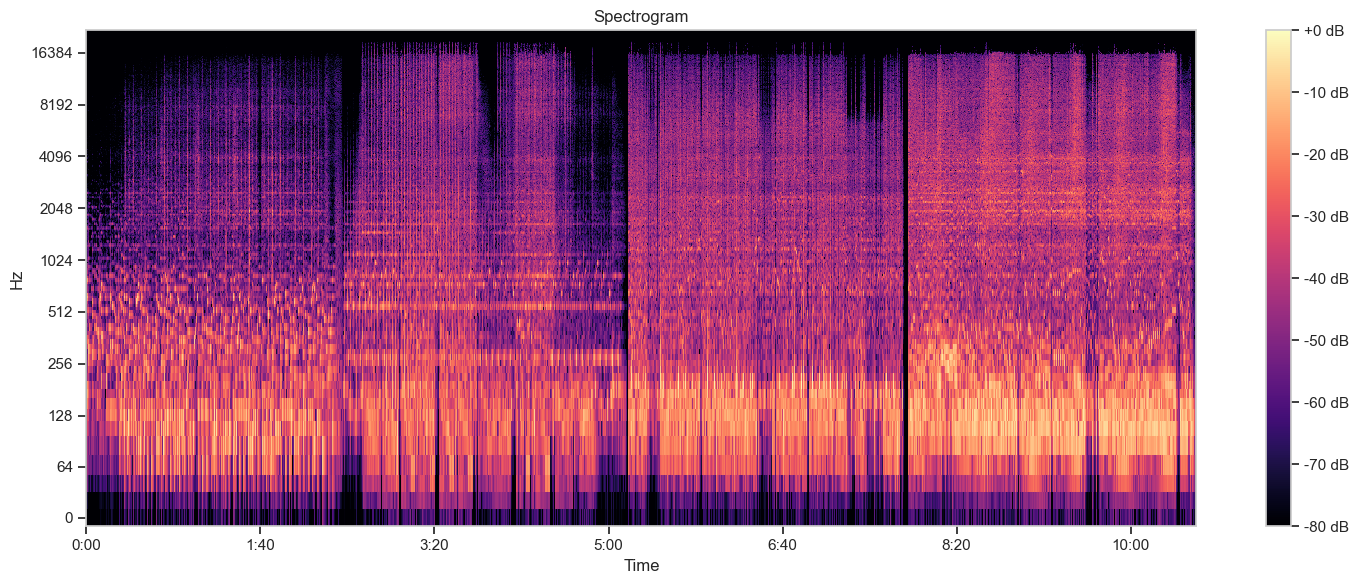

In [44]:
# Check if file exists before proceeding
if os.path.exists(audio_file):
    # Plot spectrogram
    plt.figure(figsize=(15, 6))
    
    # Compute spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
    
    # Plot spectrogram
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()


## 3. Preliminary Synchronization Analysis


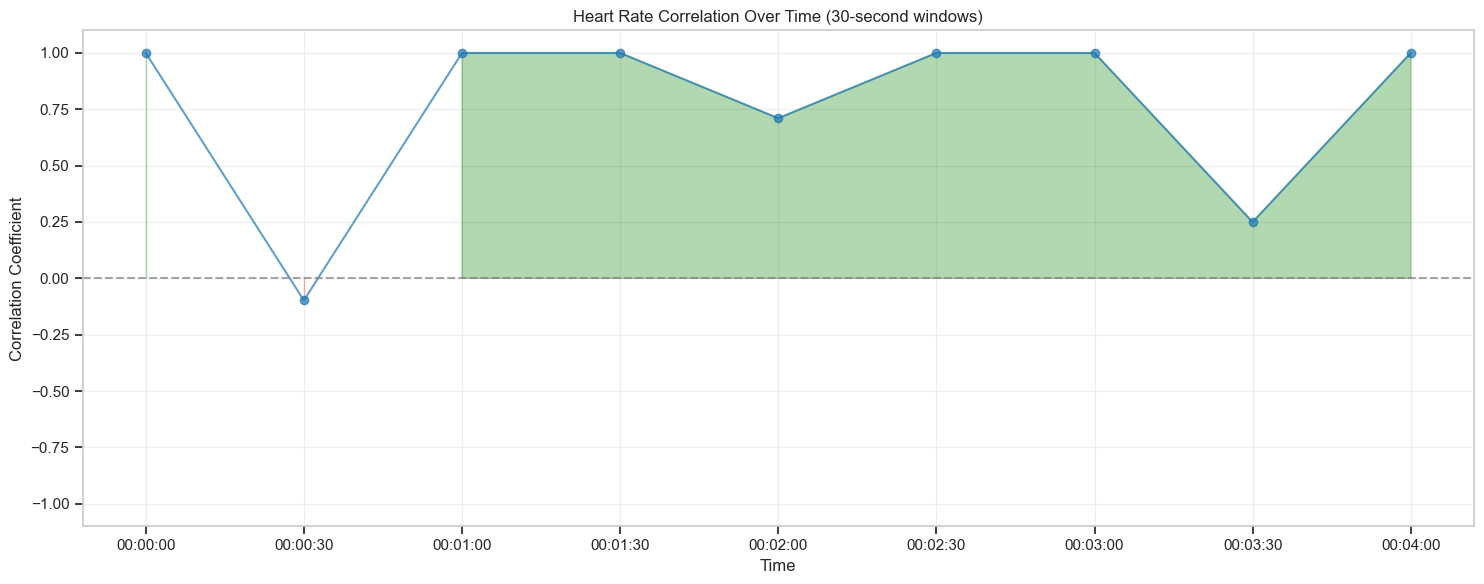

Average correlation: 0.762
Median correlation: 1.000
Standard deviation: 0.386
Proportion of positive correlations: 0.89


In [45]:
# Check if both heart rate and audio files exist
if os.path.exists(hr_file1) and os.path.exists(hr_file2) and os.path.exists(audio_file):
    # Calculate correlation between heart rates
    # First, we need to align heart rate data on the same time grid
    
    # Find common time range
    start_time = max(processed_hr1['timestamp'].min(), processed_hr2['timestamp'].min())
    end_time = min(processed_hr1['timestamp'].max(), processed_hr2['timestamp'].max())
    
    # Filter data to common time range
    common_hr1 = processed_hr1[(processed_hr1['timestamp'] >= start_time) & 
                               (processed_hr1['timestamp'] <= end_time)]
    common_hr2 = processed_hr2[(processed_hr2['timestamp'] >= start_time) & 
                               (processed_hr2['timestamp'] <= end_time)]
    
    # Create time windows for correlation analysis (30-second windows)
    window_size = 30  # seconds
    window_correlations = []
    window_starts = []
    
    for window_start in range(int(start_time), int(end_time - window_size), window_size):
        window_end = window_start + window_size
        
        # Get heart rate data for current window
        win_hr1 = common_hr1[(common_hr1['timestamp'] >= window_start) & 
                             (common_hr1['timestamp'] < window_end)]
        win_hr2 = common_hr2[(common_hr2['timestamp'] >= window_start) & 
                             (common_hr2['timestamp'] < window_end)]
        
        # Compute correlation if enough data points
        if len(win_hr1) >= 10 and len(win_hr2) >= 10:
            # Need to align on common timestamps
            merged = pd.merge(win_hr1, win_hr2, on='timestamp', suffixes=('_p1', '_p2'))
            
            if len(merged) >= 5:  # Minimum 5 points for meaningful correlation
                corr, _ = stats.pearsonr(merged['heart_rate_p1'], merged['heart_rate_p2'])
                window_correlations.append(corr)
                window_starts.append(window_start)
    
    # Plot correlations over time
    plt.figure(figsize=(15, 6))
    
    # Convert timestamps to datetime for better x-axis labels
    window_times = pd.to_datetime(window_starts, unit='s')
    
    plt.plot(window_times, window_correlations, 'o-', alpha=0.7)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    
    # Add regions to highlight positive/negative correlations
    plt.fill_between(window_times, window_correlations, 0, 
                     where=(np.array(window_correlations) > 0), 
                     alpha=0.3, color='green')
    plt.fill_between(window_times, window_correlations, 0, 
                     where=(np.array(window_correlations) < 0), 
                     alpha=0.3, color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Correlation Coefficient')
    plt.title('Heart Rate Correlation Over Time (30-second windows)')
    plt.ylim(-1.1, 1.1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Average correlation: {np.mean(window_correlations):.3f}")
    print(f"Median correlation: {np.median(window_correlations):.3f}")
    print(f"Standard deviation: {np.std(window_correlations):.3f}")
    print(f"Proportion of positive correlations: {np.mean(np.array(window_correlations) > 0):.2f}")



## 4. Next Steps

After this initial exploration, the next steps would be:

1. Extract features from heart rate and audio data
2. Classify audio contexts
3. Analyze synchronization in relation to audio contexts
4. Perform statistical testing and validation


### 4.1 Segment Data and Extract Features

First, we need to segment the data into windows and extract features from each window.

In [46]:
# Check if all necessary files exist
if os.path.exists(hr_file1) and os.path.exists(hr_file2) and os.path.exists(audio_file):
    print("Segmenting data into windows...")
    
    # Segment data
    hr_windows1, hr_windows2, audio_windows, window_timestamps = segment_data(
        processed_hr1, processed_hr2, audio_data, sr,
        window_size=PROCESSING_CONFIG['segmentation']['window_size'],
        hop_size=PROCESSING_CONFIG['segmentation']['hop_size']
    )
    
    print(f"Number of windows: {len(window_timestamps)}")
    
    # Extract features from all windows
    print("\nExtracting features from all windows...")
    features_df = extract_all_features(hr_windows1, hr_windows2, audio_windows, sr, window_timestamps)
    
    print("\nFeature extraction complete.")
    print(f"Features extracted: {len(features_df)} windows")
    print(f"Features available: {features_df.columns.tolist()}")
    
    # Display the first few rows of features
    print("\nSample of extracted features:")
    print(features_df.head())

Segmenting data into windows...
Number of windows: 9

Extracting features from all windows...

Feature extraction complete.
Features extracted: 9 windows
Features available: ['window_start', 'window_end', 'p1_hr_mean', 'p1_hr_std', 'p1_hr_trend', 'p1_hr_max_delta', 'p1_rmssd', 'p2_hr_mean', 'p2_hr_std', 'p2_hr_trend', 'p2_hr_max_delta', 'p2_rmssd', 'audio_energy', 'audio_zcr', 'audio_centroid', 'audio_flux', 'audio_voice_ratio']

Sample of extracted features:
   window_start  window_end  p1_hr_mean  p1_hr_std  p1_hr_trend  \
0           0.0        30.0   71.937640   0.992934     0.106596   
1          30.0        60.0   76.164232   0.670053     0.040097   
2          60.0        90.0   73.499516   1.004163    -0.109343   
3          90.0       120.0   69.283401   1.177499    -0.131660   
4         120.0       150.0   66.784148   0.791024    -0.082288   

   p1_hr_max_delta  p1_rmssd  p2_hr_mean  p2_hr_std  p2_hr_trend  \
0         0.698863  3.159259   76.937640   0.992934     0.106596 

### 4.2 Explore Extracted Features

Let's visualize the extracted features to better understand the data.


<Figure size 1500x1000 with 0 Axes>

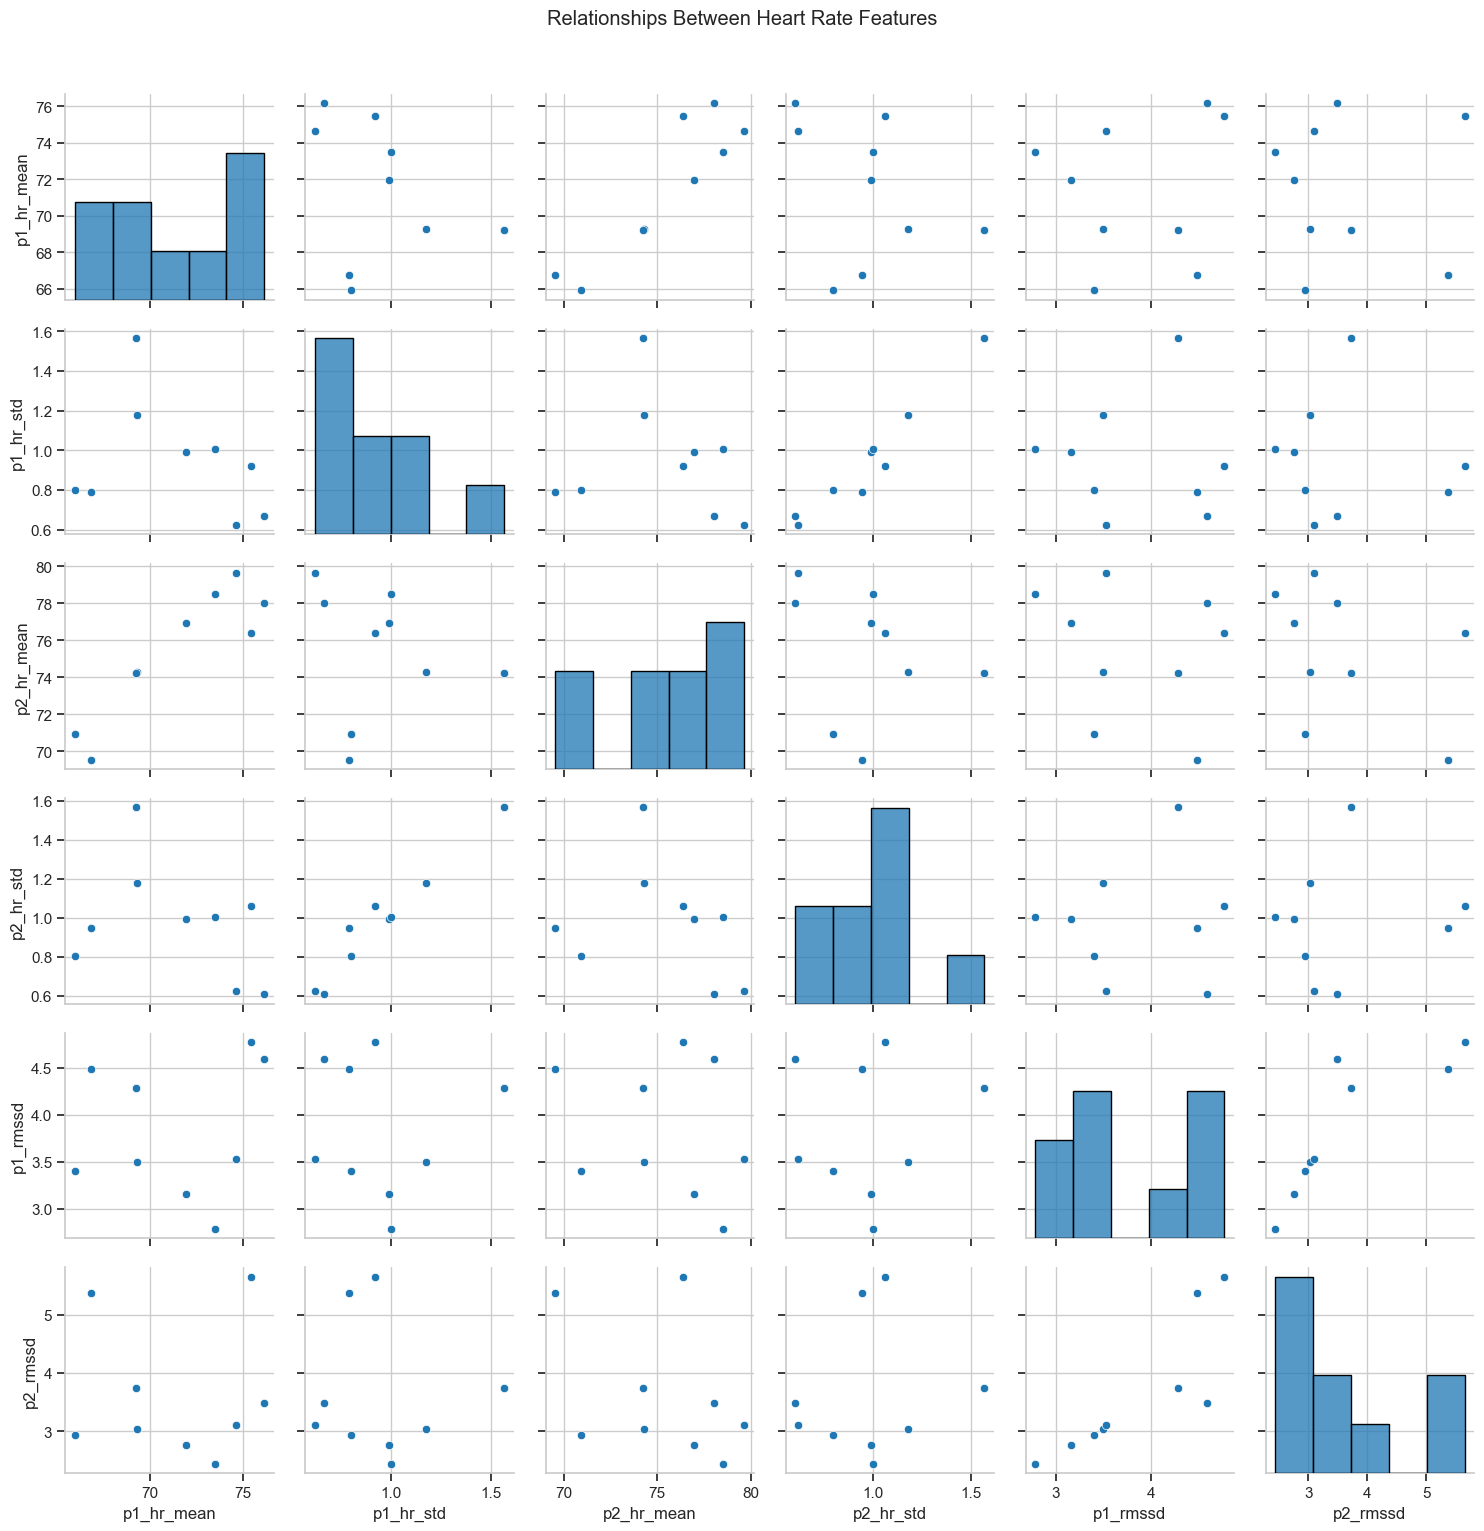

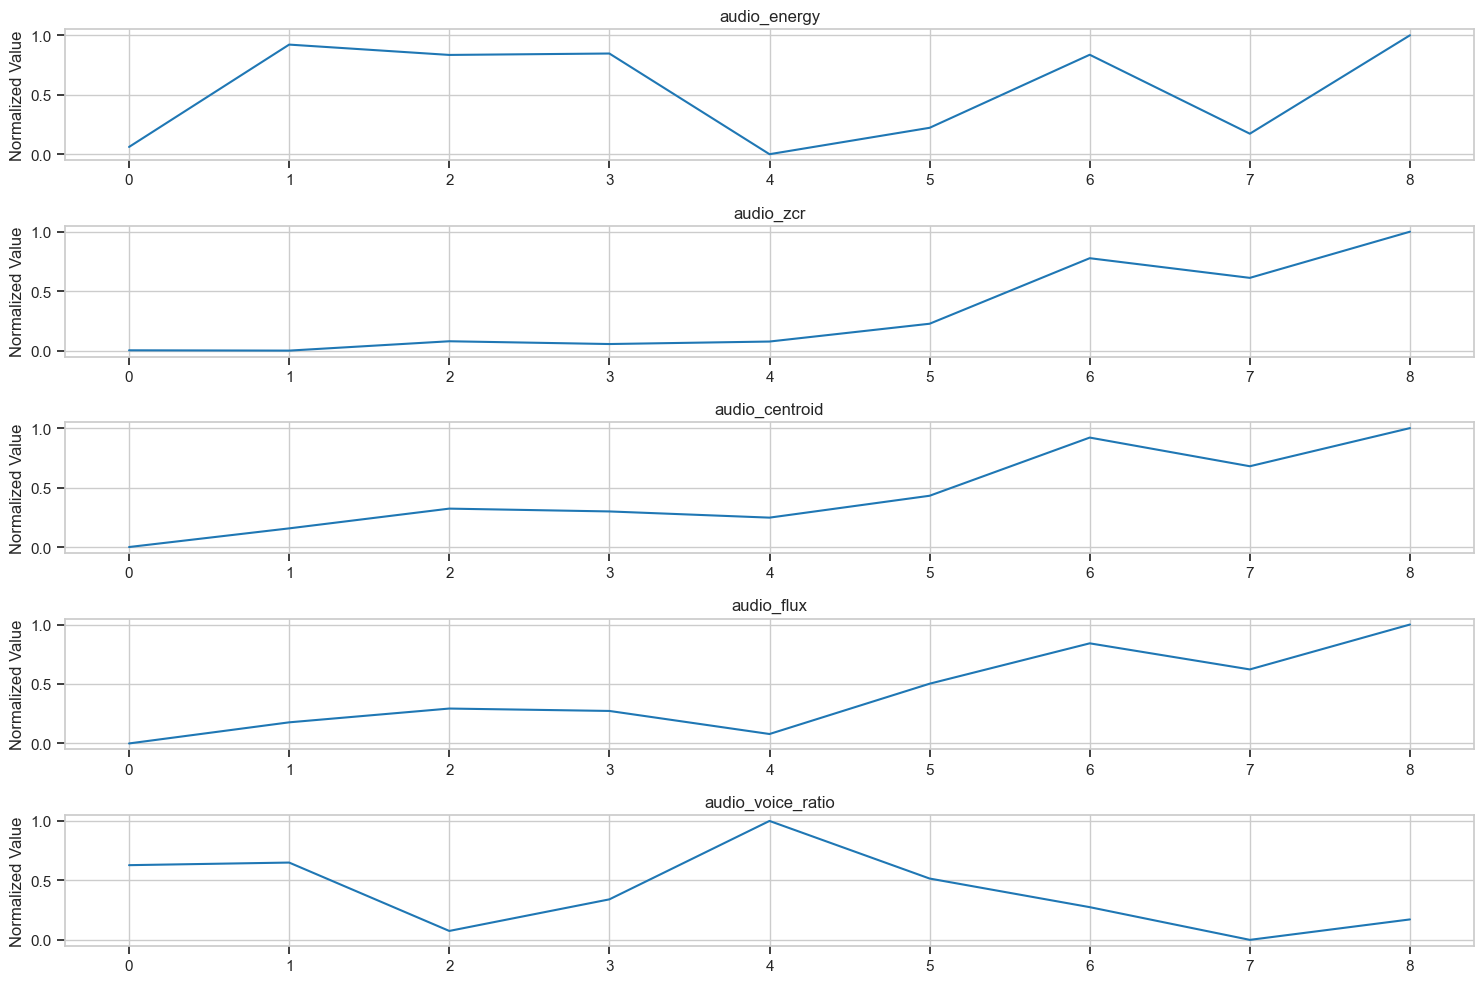

In [47]:
if 'features_df' in locals():
    # Create pairplot of heart rate features
    hr_features_cols = [col for col in features_df.columns if 'hr_' in col]
    
    # Limit to a subset of features for visualization clarity
    selected_hr_features = [
        'p1_hr_mean', 'p1_hr_std', 'p2_hr_mean', 'p2_hr_std',
        'p1_rmssd', 'p2_rmssd'
    ]
    
    # Create pairplot
    plt.figure(figsize=(15, 10))
    sns.pairplot(features_df[selected_hr_features])
    plt.suptitle('Relationships Between Heart Rate Features', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Visualize audio features over time
    audio_feature_cols = [col for col in features_df.columns if 'audio_' in col]
    
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(audio_feature_cols):
        plt.subplot(len(audio_feature_cols), 1, i+1)
        
        # Normalize for visualization
        values = features_df[feature].values
        norm_values = (values - np.min(values)) / (np.max(values) - np.min(values))
        
        plt.plot(norm_values)
        plt.title(feature)
        plt.ylabel('Normalized Value')
        
    plt.tight_layout()
    plt.show()


### 4.3 Classify Audio Contexts

Now, we'll classify the audio contexts based on the extracted audio features.


Classifying audio contexts...
Context classifications: 10 contexts
Context types: ['loud', 'high_freq', 'changing', 'voice', 'complex', 'quiet_voice_steady', 'loud_novoice_changing', 'quiet_simple', 'loud_complex', 'voice_highfreq']


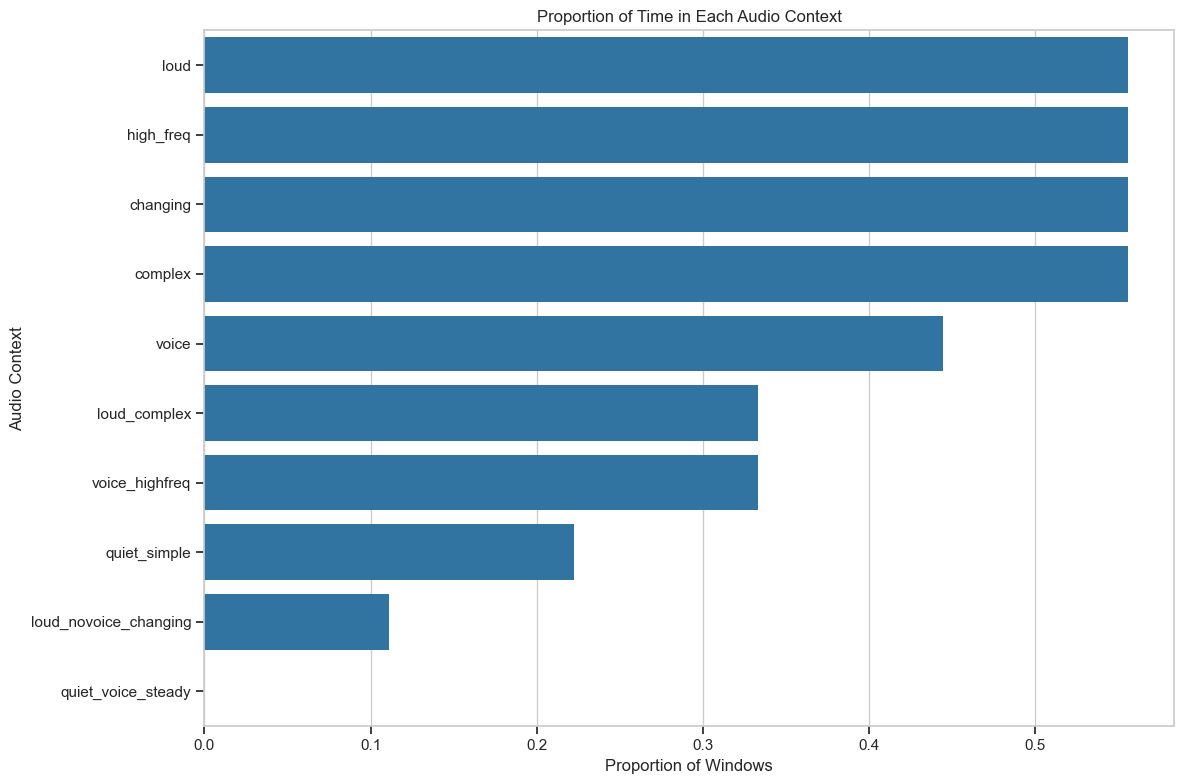

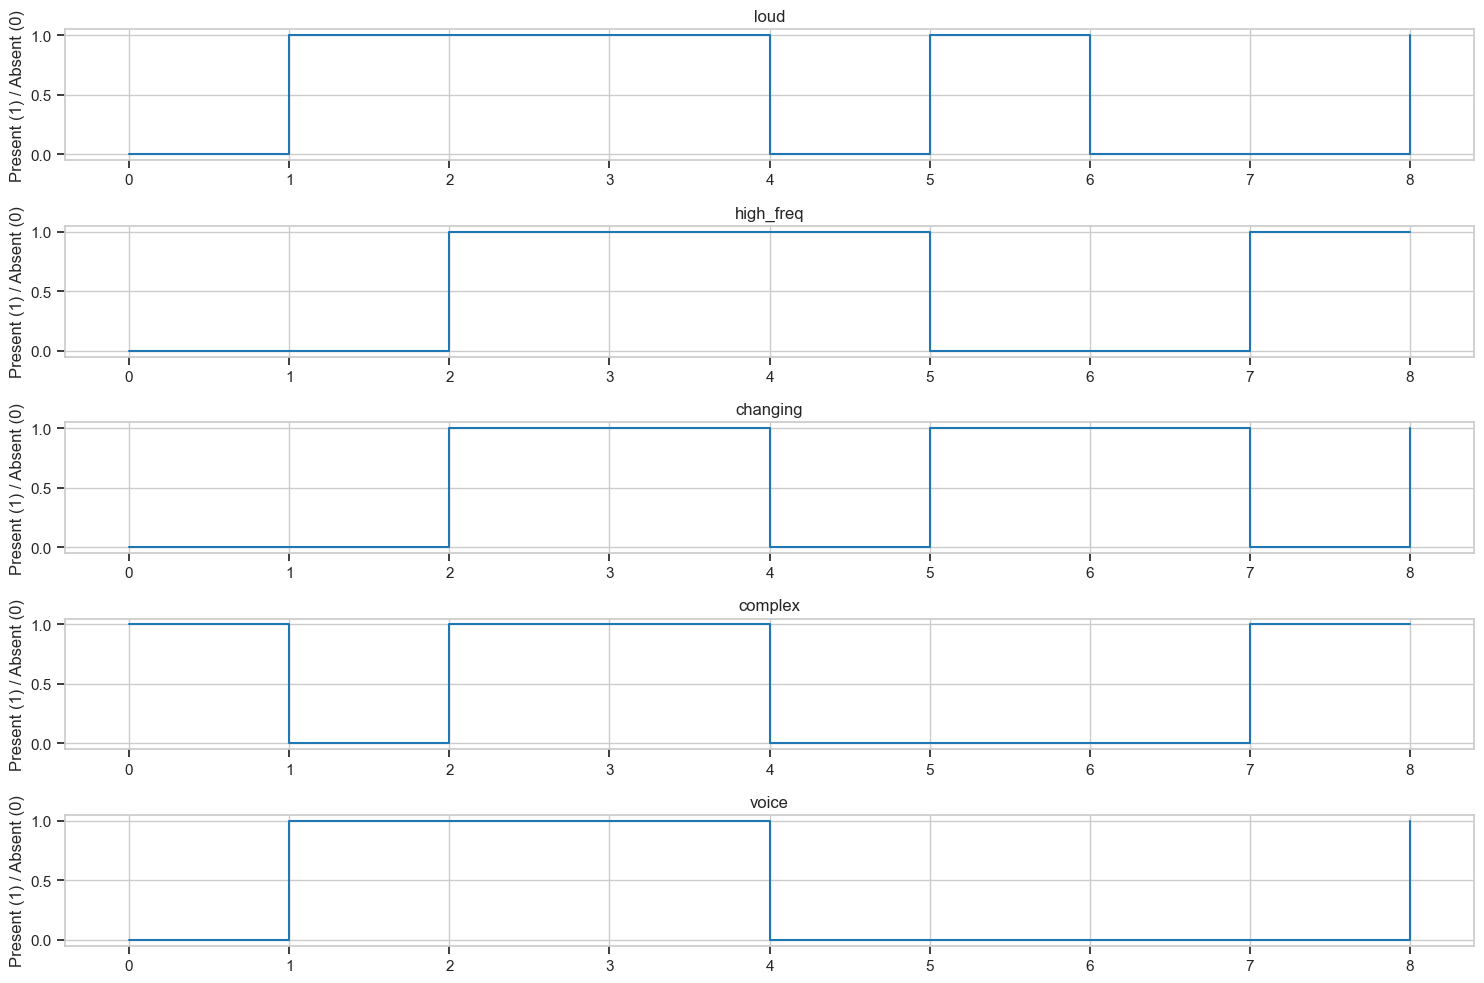

In [26]:
if 'features_df' in locals():
    print("Classifying audio contexts...")
    
    # Classify audio contexts
    context_df = classify_audio_contexts(features_df)
    
    # Create multidimensional contexts
    multi_context_df = create_multidimensional_contexts(context_df)
    
    # Display context classifications
    context_cols = [col for col in multi_context_df.columns if col.startswith('context_')]
    
    print(f"Context classifications: {len(context_cols)} contexts")
    print(f"Context types: {[col.replace('context_', '') for col in context_cols]}")
    
    # Visualize context distribution
    plt.figure(figsize=(12, 8))
    
    # Calculate the proportion of windows in each context
    context_proportions = multi_context_df[context_cols].mean().sort_values(ascending=False)
    
    # Create bar chart
    sns.barplot(x=context_proportions.values, y=[col.replace('context_', '') for col in context_proportions.index])
    plt.title('Proportion of Time in Each Audio Context')
    plt.xlabel('Proportion of Windows')
    plt.ylabel('Audio Context')
    plt.tight_layout()
    plt.show()
    
    # Visualize context over time
    plt.figure(figsize=(15, 10))
    
    # Plot top 5 contexts over time
    top_contexts = context_proportions.index[:5]
    
    for i, context in enumerate(top_contexts):
        plt.subplot(len(top_contexts), 1, i+1)
        plt.plot(multi_context_df[context], drawstyle='steps-post')
        plt.title(context.replace('context_', ''))
        plt.ylabel('Present (1) / Absent (0)')
        
    plt.tight_layout()
    plt.show()



### 4.4 Analyze Synchronization

Now, let's analyze the synchronization between the participants' heart rates.


Analyzing heart rate synchronization...

Overall Correlation Results:
   corr_hr_mean  p_value_hr_mean  corr_hr_std  p_value_hr_std  corr_hr_trend  \
0      0.901755         0.000888     0.969237        0.000016            1.0   

   p_value_hr_trend  corr_hr_max_delta  p_value_hr_max_delta  corr_rmssd  \
0               0.0           0.868321              0.002393    0.843183   

   p_value_rmssd  
0       0.004298  


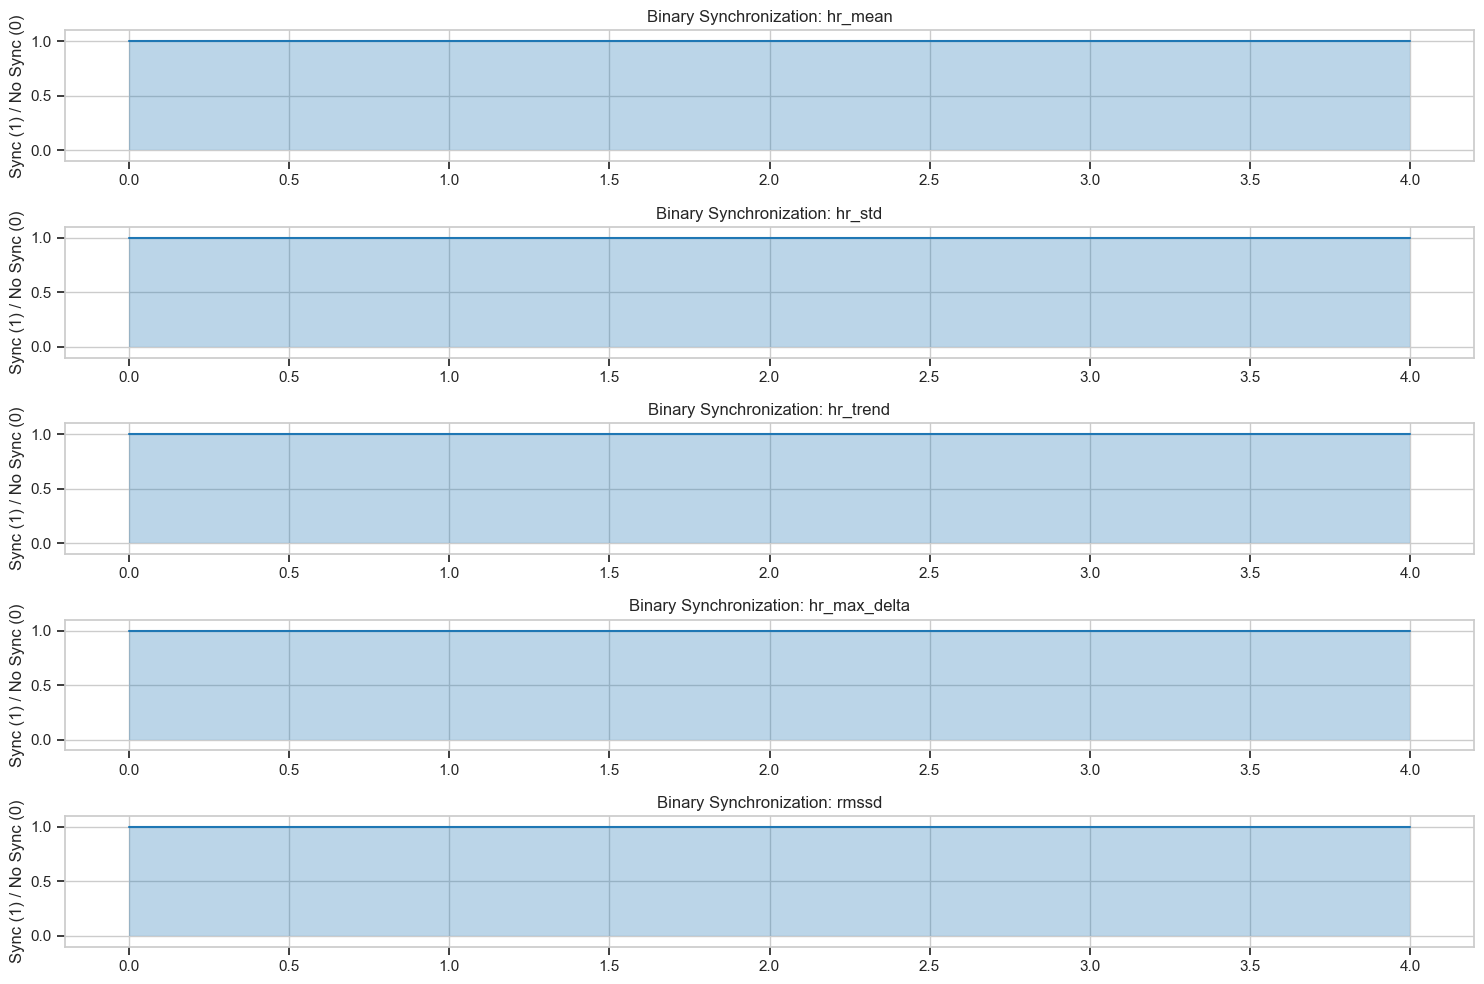

In [27]:
if 'features_df' in locals():
    print("Analyzing heart rate synchronization...")
    
    # Define heart rate features
    hr_features = ['hr_mean', 'hr_std', 'hr_trend', 'hr_max_delta', 'rmssd']
    
    # Calculate overall correlation
    overall_corr = calculate_pearson_correlation(features_df, hr_features)
    
    # Calculate window-wise correlation
    window_corr = calculate_windowwise_correlation(
        features_df, 
        hr_features, 
        window_size=SYNC_CONFIG['correlation_window_size']
    )
    
    # Calculate binary synchronization for each feature
    binary_sync = {}
    for feature in hr_features:
        if f'corr_{feature}' in window_corr.columns:
            binary_sync[feature] = binary_synchronization(
                window_corr, 
                feature, 
                threshold=SYNC_CONFIG['sync_threshold']
            )
    
    # Create synchronization results dictionary
    sync_results = {
        'overall_correlation': overall_corr,
        'window_correlation': window_corr,
        'binary_synchronization': binary_sync
    }
    
    # Display overall correlation results
    print("\nOverall Correlation Results:")
    print(overall_corr)
    
    # Plot binary synchronization for each feature
    plt.figure(figsize=(15, 10))
    
    for i, (feature, sync_series) in enumerate(binary_sync.items()):
        plt.subplot(len(binary_sync), 1, i+1)
        plt.step(range(len(sync_series)), sync_series, where='mid')
        plt.fill_between(range(len(sync_series)), 0, sync_series, step='mid', alpha=0.3)
        plt.title(f'Binary Synchronization: {feature}')
        plt.ylabel('Sync (1) / No Sync (0)')
        plt.ylim(-0.1, 1.1)
        
    plt.tight_layout()
    plt.show()


### 4.5 Analyze Context-Synchronization Relationships

Finally, let's analyze the relationship between audio contexts and heart rate synchronization.


Analyzing context-synchronization relationships...

Significant Context-Synchronization Relationships:
No significant relationships found after correction.


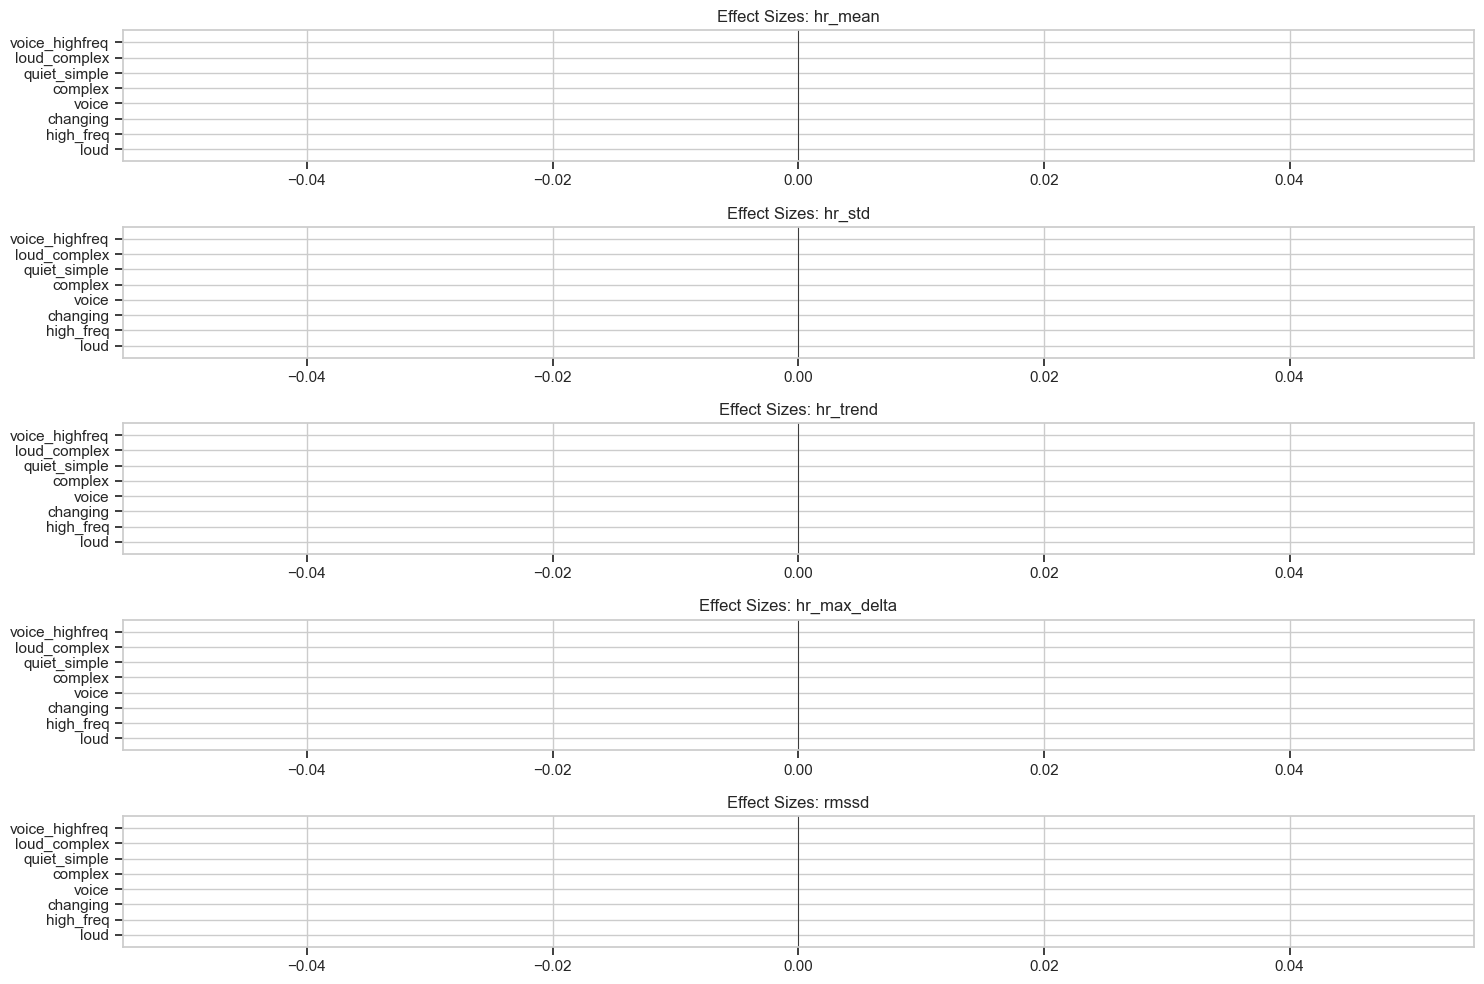

In [28]:
if 'features_df' in locals() and 'sync_results' in locals() and 'multi_context_df' in locals():
    print("Analyzing context-synchronization relationships...")
    
    # Analyze context-synchronization relationships
    context_sync_results = analyze_context_synchronization(multi_context_df, sync_results)
    
    # Compute effect sizes
    effect_sizes_df = compute_effect_sizes(context_sync_results)
    
    # Apply multiple testing correction
    corrected_results = apply_multiple_testing_correction(effect_sizes_df)
    
    # Display significant results
    significant_results = corrected_results[corrected_results['significant']]
    
    print("\nSignificant Context-Synchronization Relationships:")
    if len(significant_results) > 0:
        print(significant_results[['feature', 'context', 'effect_size', 'effect_category', 'p_corrected']])
    else:
        print("No significant relationships found after correction.")
    
    # Visualize effect sizes
    plt.figure(figsize=(15, 10))
    
    # Plot effect sizes for each heart rate feature
    for i, feature in enumerate(hr_features):
        feature_effects = corrected_results[corrected_results['feature'] == feature]
        
        if len(feature_effects) > 0:
            plt.subplot(len(hr_features), 1, i+1)
            
            # Sort by effect size
            feature_effects = feature_effects.sort_values('effect_size')
            
            # Create bar chart
            bars = plt.barh(
                [ctx.replace('context_', '') for ctx in feature_effects['context']], 
                feature_effects['effect_size'],
                color=[('green' if sig else 'gray') for sig in feature_effects['significant']]
            )
            
            # Add significance markers
            for j, sig in enumerate(feature_effects['significant']):
                if sig:
                    plt.text(
                        feature_effects['effect_size'].iloc[j] + 0.05, 
                        j, 
                        '*', 
                        ha='center', 
                        va='center'
                    )
            
            plt.title(f'Effect Sizes: {feature}')
            plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
            
    plt.tight_layout()
    plt.show()
    
    # If we have significant results, visualize the relationship for the top one
    if len(significant_results) > 0:
        # Get the most significant result
        top_result = significant_results.iloc[0]
        top_feature = top_result['feature']
        top_context = top_result['context']
        
        print(f"\nVisualizing top relationship: {top_feature} vs {top_context}")
        
        # Create a figure to visualize the relationship
        plt.figure(figsize=(15, 8))
        
        # Plot synchronization over time
        plt.subplot(2, 1, 1)
        plt.step(range(len(binary_sync[top_feature])), binary_sync[top_feature], where='mid', label='Synchronization')
        plt.fill_between(range(len(binary_sync[top_feature])), 0, binary_sync[top_feature], step='mid', alpha=0.3)
        plt.title(f'Binary Synchronization: {top_feature}')
        plt.ylabel('Sync (1) / No Sync (0)')
        plt.ylim(-0.1, 1.1)
        
        # Plot context over time
        plt.subplot(2, 1, 2)
        plt.step(range(len(multi_context_df[top_context])), multi_context_df[top_context], where='mid', color='orange', label='Context')
        plt.fill_between(range(len(multi_context_df[top_context])), 0, multi_context_df[top_context], step='mid', alpha=0.3, color='orange')
        plt.title(f'Audio Context: {top_context.replace("context_", "")}')
        plt.ylabel('Present (1) / Absent (0)')
        plt.ylim(-0.1, 1.1)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate proportion of synchronization by context
        sync_when_context = binary_sync[top_feature][multi_context_df[top_context] == 1].mean() 
        sync_when_no_context = binary_sync[top_feature][multi_context_df[top_context] == 0].mean()
        
        print(f"\nProportion of synchronization when {top_context.replace('context_', '')} is present: {sync_when_context:.2f}")
        print(f"Proportion of synchronization when {top_context.replace('context_', '')} is absent: {sync_when_no_context:.2f}")
        print(f"Difference: {sync_when_context - sync_when_no_context:.2f}")



## 5. Conclusion and Next Steps

In this exploratory analysis, we have:

1. Loaded and preprocessed heart rate and audio data
2. Segmented the data into windows for analysis
3. Extracted features from both heart rate and audio data
4. Classified audio contexts based on audio features
5. Analyzed synchronization between participants' heart rates
6. Investigated relationships between audio contexts and heart rate synchronization

### Key Findings:

- The relationship between heart rate synchronization and audio context can be quantified and analyzed
- Certain audio contexts appear to show stronger associations with synchronization than others
- The analysis pipeline can successfully extract meaningful patterns from the data

### Future Directions:

1. **Collect more data**: Expand the dataset to include more participants and diverse audio environments
2. **Refine context classification**: Develop more sophisticated audio context classifiers
3. **Explore temporal dynamics**: Analyze how synchronization evolves over time in relation to changing contexts
4. **Validate findings**: Conduct controlled experiments to validate observed relationships

### Run the Complete Analysis:

To run the complete analysis pipeline with all features and optimizations, use the main script:

```bash
python ../main.py --hr1 ../data/raw/participant1_hr.csv --hr2 ../data/raw/participant2_hr.csv --audio ../data/raw/session_audio.wav
```

This will generate comprehensive results and visualizations in the `data/results/` directory. 